In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import PIL
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Define the directory path containing the images
training = r"C:\Users\Colin\OneDrive\Desktop\Machine Learning\Training - Copy\Training"

#### If this does not run, use this diretory and it should be okay
# project_dir = r"C:\Users\Colin\OneDrive\Desktop\Machine Learning\project\Training - Copy\Training"

# Specify the image dimensions and batch size
image_size = (128,128)
input_shape = (128,128,3)
batch_size = 32

# Setting up the data set 80/20 for testing/training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size,)

# Validating data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Expressions = train_ds.class_names
print(Expressions)

num_classes = len(Expressions)

# Prefetching for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Data Augmentation and Rescaling

data_augmentation = keras.Sequential(
  [
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal", input_shape=input_shape),      
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.01),
  ]
)

# Model Definition and Convolutional layers
Model_CNN = None

model_CNN = keras.Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.5), name="outputs")
])

model_CNN.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

# input_shape = (None, 64, 64, 3)  # Batch size, height, width, channels
# model_CNN.build(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

#model_CNN.summary()
epochs = 15
history = model_CNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
  )


Found 28273 files belonging to 3 classes.
Using 22619 files for training.
Found 28273 files belonging to 3 classes.
Using 5654 files for validation.
['Angry', 'Happy', 'Other']
Epoch 1/15
 25/707 [>.............................] - ETA: 13:39 - loss: 4.2461 - accuracy: 0.4963

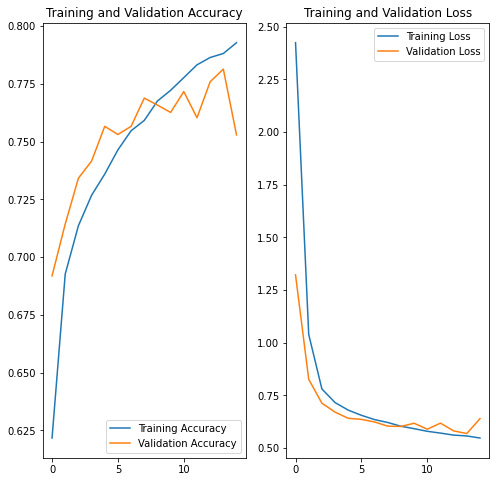

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
testing = r"C:\Users\Colin\OneDrive\Desktop\Machine Learning\Testing - Copy\Testing"

### Run this with proj_dir if trainng/testing directories dont work 
## proj_dir_test = r"C:\Users\Colin\OneDrive\Desktop\Machine Learning\project\Testing - Copy\Testing"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  testing,
  seed=123,
  image_size=image_size,
  batch_size=batch_size,)

# Perform data augmentation and rescaling on the testing dataset
test_ds = test_ds.map(lambda x, y: (data_augmentation(x, training=False), y))

# Prefetch for performance
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Test the model on the testing dataset
test_loss, test_accuracy = model_CNN.evaluate(test_ds, verbose=2)

print('\nTest accuracy:', test_accuracy)
print('The testing data has an accuracy of approximately {a:}%'.format(a = np.round(test_accuracy * 100,2)))

Found 7067 files belonging to 3 classes.
221/221 - 42s - loss: 1.1481 - accuracy: 0.6134 - 42s/epoch - 191ms/step

Test accuracy: 0.613414466381073
The testing data has an accuracy of approximately 61.34%
